<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/materials/2_handson/jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvidia-smi

Tue Feb 28 11:21:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |  11723MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np 
from functools import partial
import matplotlib.pyplot as plt


We consider a classical Coulomb gas with the Hamiltonian 

$$H= \sum_{i<j} \frac{1}{|\boldsymbol{x}_i - \boldsymbol{x}_j|} + \sum_i  \boldsymbol{x}_i^2 , $$
where the two terms are Coulomb interaction and harmonic trapping potential respectively.

In [10]:
def energy_fn(x, n, dim):
    i, j = jnp.triu_indices(n, k=1)
    r_ee = jnp.linalg.norm((jnp.reshape(x, (n, 1, dim)) - jnp.reshape(x, (1, n, dim)))[i,j], axis=-1)
    v_ee = jnp.sum(1/r_ee)
    return jnp.sum(x**2) + v_ee

We can obtain the gradient function via `jax.grad`

In [11]:
grad_fn = jax.grad(energy_fn)

Let's have a look at particles and force

(-3.0, 3.0)

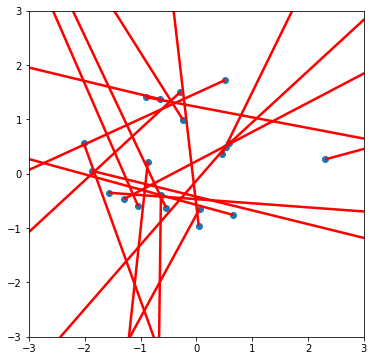

In [30]:
n, dim = 20, 2
key = jax.random.PRNGKey(42)
x = jax.random.normal(key, (n, dim)) # random particle position
f = grad_fn(x, n, dim)

fig = plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1])
plt.quiver(x[:, 0], x[:, 1], f[:, 0], f[:, 1], color='red', scale=1)

plt.xlim([-3, 3])
plt.ylim([-3, 3])

## Ground state 

We want to find the minimal energy configuration

$$x^\ast  = \mathrm{argmin}_{x} H(x) .$$

For that, we carry out a gradient descent

$$x \leftarrow x - \eta \frac{\partial H }{\partial x}$$ 



In [31]:
def optimize(x, steps=500, eta=1e-2):
    for _ in range(steps):
        x = x - eta * grad_fn(x, n, dim)
    return x

Run the optimization, and have a look at the result!

In [32]:
x = optimize(x)

(-3.0, 3.0)

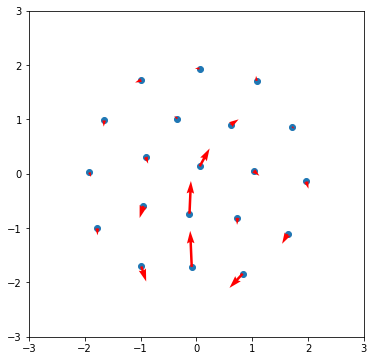

In [33]:
fig = plt.figure(figsize=(6, 6))

f = grad_fn(x, n, dim)
plt.scatter(x[:, 0], x[:, 1])
plt.quiver(x[:, 0], x[:, 1], f[:, 0], f[:, 1], color='red', scale=1)

plt.xlim([-3, 3])
plt.ylim([-3, 3])

We can actually run a batch of optimizations in parallel with `vmap`

In [34]:
batchsize = 64
x = jax.random.normal(key, (batchsize, n, dim))
x = jax.vmap(optimize)(x)

(-3.0, 3.0)

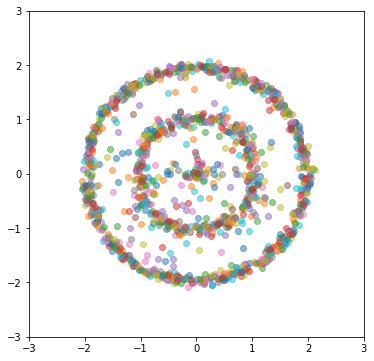

In [35]:
fig = plt.figure(figsize=(6, 6))

for b in range(batchsize):
    plt.scatter(x[b, :, 0], x[b, :, 1], alpha=0.5)
plt.xlim([-3, 3])
plt.ylim([-3, 3])

## Finite temperature

We want to sample configuation from the equlibrium Boltzman distribution 

$$ x\sim \frac{e^{-\beta H(x)}}{Z}. $$ 


For that, we will use the Metropolis Monte Carlo algorithms. We randomly move the particles, and accept the move with probability 

$$ A(x \rightarrow x^\prime ) = \min \left[ 1, \frac{e^{-\beta H(x^\prime)}}{e ^{-\beta H(x)}} \right] $$ 






In [36]:
@partial(jax.jit, static_argnums=0)
def mcmc(logp_fn, x_init, key, mc_steps, mc_width):
    """
        Markov Chain Monte Carlo sampling algorithm.

    INPUT:
        logp_fn: callable that evaluate log-probability of a batch of configuration x.
            The signature is logp_fn(x), where x has shape (batch, n, dim).
        x_init: initial value of x, with shape (batch, n, dim).
        key: initial PRNG key.
        mc_steps: total number of Monte Carlo steps.
        mc_width: size of the Monte Carlo proposal.

    OUTPUT:
        x: resulting batch samples, with the same shape as `x_init`.
    """
    def step(i, state):
        x, logp, key, num_accepts = state
        key, key_proposal, key_accept = jax.random.split(key, 3)
        
        x_proposal = x + mc_width * jax.random.normal(key_proposal, x.shape)
        logp_proposal = logp_fn(x_proposal)

        ratio = jnp.exp((logp_proposal - logp))
        accept = jax.random.uniform(key_accept, ratio.shape) < ratio

        x_new = jnp.where(accept[:, None, None], x_proposal, x)
        logp_new = jnp.where(accept, logp_proposal, logp)
        num_accepts += accept.sum()
        return x_new, logp_new, key, num_accepts
    
    logp_init = logp_fn(x_init)

    x, logp, key, num_accepts = jax.lax.fori_loop(0, mc_steps, step, (x_init, logp_init, key, 0.))
    accept_rate = num_accepts / (mc_steps * x.shape[0])
    return x, accept_rate

In [39]:
@partial(jax.vmap, in_axes=(0, None, None, None))
def logp(x, n, dim, beta):
    return -beta * energy_fn(x, n, dim)

beta = 10.0 # inverse temperature
batchsize = 8192
mc_steps = 100 
mc_width = 0.02

x = jax.random.normal(key, (batchsize, n, dim))

for i in range(20):
    key, subkey = jax.random.split(key)
    x, acc = mcmc(lambda x: logp(x, n, dim, beta), x, subkey, mc_steps, mc_width)
    print (i, acc)

0 0.500465087890625
1 0.542105712890625
2 0.57940673828125
3 0.60908203125
4 0.628472900390625
5 0.63960205078125
6 0.64501708984375
7 0.6482080078125
8 0.6509423828125
9 0.651187744140625
10 0.6519970703125
11 0.651953125
12 0.65368896484375
13 0.652696533203125
14 0.652987060546875
15 0.65283203125
16 0.65235107421875
17 0.65237060546875
18 0.6536083984375
19 0.652716064453125


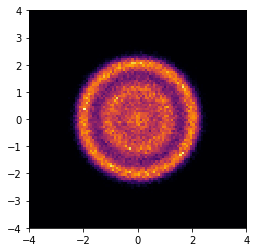

In [40]:
x = jnp.reshape(x, (batchsize*n, dim)) 
#density plot
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], 
                                   bins=100, 
                                   range=((-4, 4), (-4, 4)),
                        density=True)

plt.imshow(H, interpolation="nearest", 
               extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
               cmap="inferno")